In [0]:
#Import dependencies
import cv2
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
from matplotlib import pyplot as plt
import imghdr
from pyspark.sql.types import ArrayType, IntegerType

In [0]:
#Set Spark conf to access ADLS
spark.conf.set(f"fs.azure.account.auth.type.{dbutils.secrets.get('storageaccount', 'storageaccount')}.dfs.core.windows.net", "SAS")
spark.conf.set(f"fs.azure.sas.token.provider.type.{dbutils.secrets.get('storageaccount', 'storageaccount')}.dfs.core.windows.net", "org.apache.hadoop.fs.azurebfs.sas.FixedSASTokenProvider")
spark.conf.set(f"fs.azure.sas.fixed.token.{dbutils.secrets.get('storageaccount', 'storageaccount')}.dfs.core.windows.net", f"{dbutils.secrets.get('storageaccount', 'sastoken')}")

In [0]:
#Read image from ADLS as Spark DF
df = spark.read.format("image").load(f"abfss://nga-ml@{dbutils.secrets.get('storageaccount', 'storageaccount')}.dfs.core.windows.net/clean_room/clean_room_2.jpg")

In [0]:
#Show image metadata
df.select("image.height", "image.width"
         ,"image.nChannels", "image.mode"
         ,"image.data").show()

+------+-----+---------+----+--------------------+
|height|width|nChannels|mode|                data|
+------+-----+---------+----+--------------------+
|  1000|  667|        3|  16|[7B 7C 8A 7A 7B 8...|
+------+-----+---------+----+--------------------+



In [0]:
#Convert bytearray to numpy ndarray
img_array = np.array(df.select('image.data').collect()[0]['data'])

#Reshape numpy.ndarray to height x width x channels
img_array = img_array.reshape((1000, 667, 3))

#Check shape
img_array.shape

Out[5]: (1000, 667, 3)

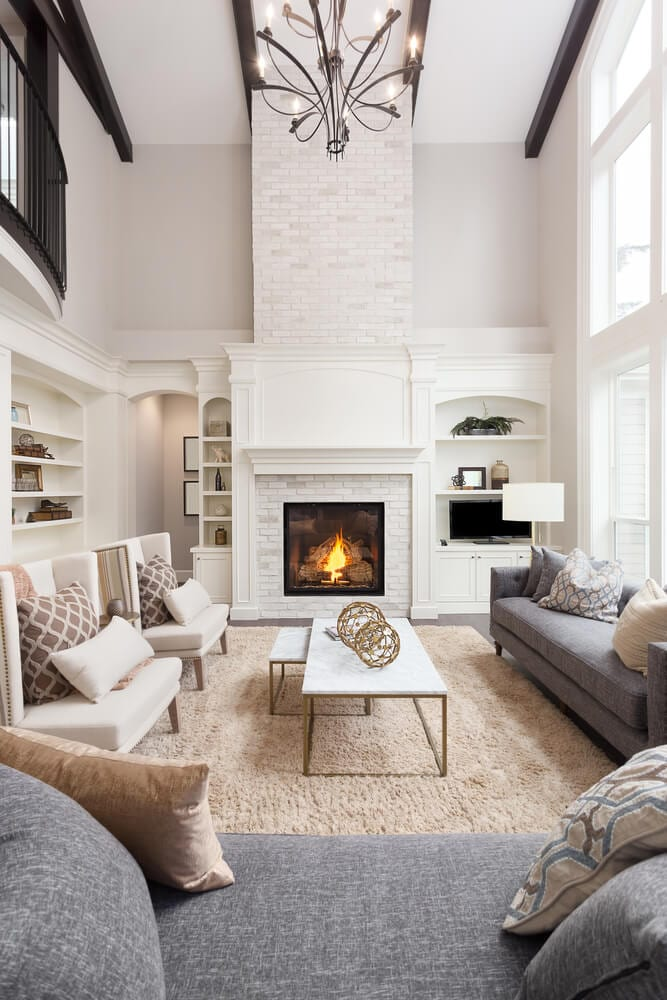

In [0]:
#View image
from dbruntime.patches import cv2_imshow
cv2_imshow(img_array)

In [0]:
#Mount ADLS
config = {"fs.azure.account.key.teststorageaccount1171.blob.core.windows.net":f"{dbutils.secrets.get('storageaccount', 'container-accesskeys')}"}

dbutils.fs.mount(
  source = "wasbs://nga-ml@teststorageaccount1171.blob.core.windows.net",
  mount_point = "/mnt/nga-ml",
  extra_configs = config)

In [0]:
# Clean images by removing any corrupt images
data_dir = "/dbfs/mnt/nga-ml"
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print("Image not in ext list {}".format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}".format(image_path))

In [0]:
# Load image datasets using TF
data = tf.keras.utils.image_dataset_from_directory("/dbfs/mnt/nga-ml")

Found 516 files belonging to 2 classes.


In [0]:
# Create iterator
data_iterator = data.as_numpy_iterator()

In [0]:
batch = data_iterator.next()

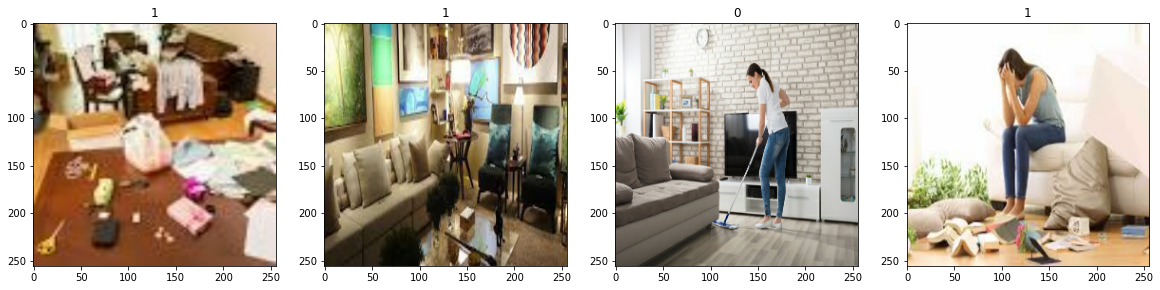

In [0]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [0]:
# Scale data
data = data.map(lambda x, y: (x/255, y))

In [0]:
scaled_iterator = data.as_numpy_iterator()

In [0]:
batch = scaled_iterator.next()

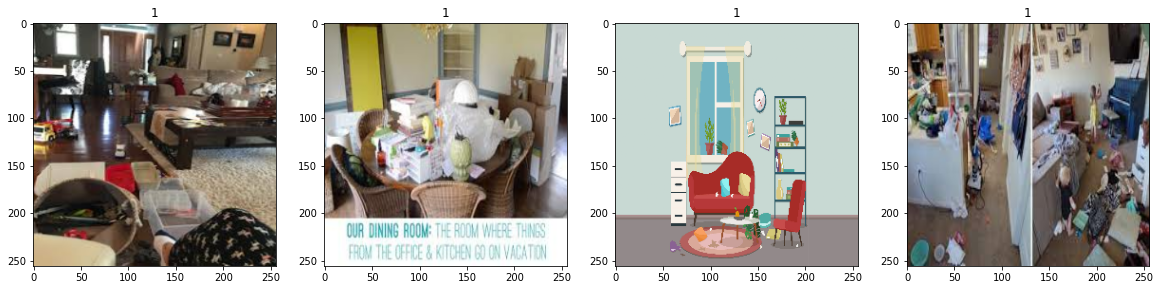

In [0]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])


In [0]:
# Split data
train_size = int(len(data) * 0.7) + 1
val_size = int(len(data) * 0.2) + 1
test_size = int(len(data) * 0.1)

In [0]:
 train_size + val_size + test_size == len(data)

Out[24]: True

In [0]:
# Partition data
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [0]:
# Build model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [0]:
model = Sequential()

In [0]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [0]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [0]:
# # Setup logging
# logdir = "/dbfs/mnt/logs"
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [0]:
#Epochs to be 20
hist = model.fit(train, epochs=20, validation_data=val)


Epoch 1/20
12/12 [==============================] - 58s 4s/step - loss: 1.0078 - accuracy: 0.5234 - val_loss: 0.6096 - val_accuracy: 0.7109
Epoch 2/20
12/12 [==============================] - 55s 4s/step - loss: 0.5789 - accuracy: 0.6823 - val_loss: 0.5262 - val_accuracy: 0.7109
Epoch 3/20
12/12 [==============================] - 56s 4s/step - loss: 0.4789 - accuracy: 0.6927 - val_loss: 0.5348 - val_accuracy: 0.6562
Epoch 4/20
12/12 [==============================] - 55s 4s/step - loss: 0.4659 - accuracy: 0.6849 - val_loss: 0.4260 - val_accuracy: 0.7266
Epoch 5/20
12/12 [==============================] - 59s 4s/step - loss: 0.4319 - accuracy: 0.8385 - val_loss: 0.4235 - val_accuracy: 0.7891
Epoch 6/20
12/12 [==============================] - 71s 5s/step - loss: 0.3695 - accuracy: 0.8672 - val_loss: 0.3015 - val_accuracy: 0.8828
Epoch 7/20
12/12 [==============================] - 54s 4s/step - loss: 0.3264 - accuracy: 0.8750 - val_loss: 0.2554 - val_accuracy: 0.9062
Epoch 8/20
12/12 [==

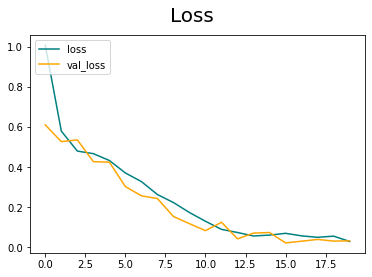

In [0]:
# Plot performance
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

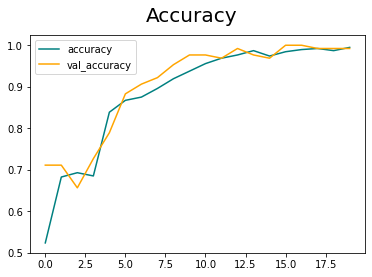

In [0]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [0]:
# Evaluate
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [0]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [0]:
for batch in test.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 169ms/step


In [0]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


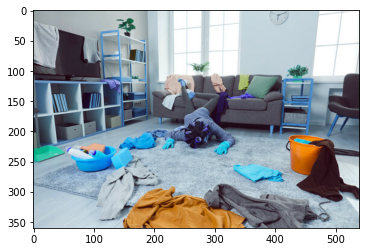

In [0]:
# Test
img = cv2.imread("/dbfs/mnt/nga-ml/dirty_living.jpg")
plt.imshow(img)
plt.show()

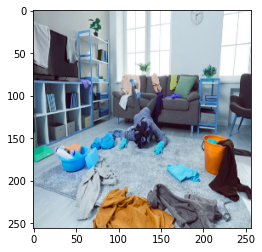

In [0]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [0]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 54ms/step


In [0]:
yhat

Out[42]: array([[0.9991038]], dtype=float32)

In [0]:
if yhat > 0.5:
    print("Predicted class is Messy")
else:
    print("Predicted class is Clean")

Predicted class is Messy


In [0]:
# Save model on Databricks

(360, 540, 3)


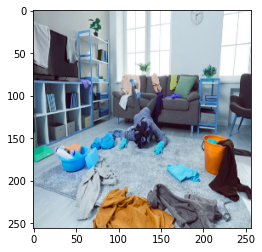

1/1 [==============================] - 0s 33ms/step


In [0]:
### Rough

# Test - processing new image being streamed as string array
img = cv2.imread("/dbfs/mnt/nga-ml/dirty_living.jpg")

# Convert to str
msg = str(img)

# Flatten
msg_flat = img.flatten()
msg_flat.shape

# Convert to bytes
msg_bytes = msg_flat.tobytes()

# Convert bytes to array
msg_back_to_array = np.array(list(msg_bytes))

# New reshaped array should be same as original img
print(img.shape)
msg_back_to_array = msg_back_to_array.reshape((360, 540, 3))

# Resize and display
resize = tf.image.resize(msg_back_to_array, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

# Use ML model to predict
yhat = model.predict(np.expand_dims(resize/255, 0))